In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
import pymc3 as pm
import numpy as np
import theano

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#this command must be run for theano to work... maybe add it in the activate script


# export MKL_THREADING_LAYER=GNU

In [5]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1)
    obs = pm.Normal('obs', mu=mu, sd=1, observed=np.random.randn(100))

In [9]:
model.observed_RVs

[obs]

In [10]:
model.logp({'mu':0})

array(-146.43294360720742)

In [5]:
#import data
import random

colour_dict = {'blue':(0,0,1),
                   'yellow':(1,1,0),
                   'red':(1,0,0),
                   'green':(0, 1, 0)}
def colour_model(colour):
    sample = np.absolute(np.random.randn(3)*0.1)
    out = np.zeros(3)
    for i, dim in enumerate(colour):
        if dim == 0:
            out[i] = min(dim + sample[i], 1)
        else:
            out[i] = max(dim - sample[i], 0)
    return tuple(out)

def generate_data(colour ,n):
    colours = ['blue', 'green', 'red', 'yellow']
    data = []
    for i in range(n):

        data.append(colour_model(colour_dict[colour]))
    return data

data_dict = {c:generate_data(c, 2) for c in ['red', 'green', 'blue', 'yellow']}
objs = {}
n = 2
for j, c in enumerate(['red', 'green', 'blue', 'yellow']):
    for i in range(n):
        objs["o{}".format(j*n + i)] = (c, data_dict[c][i])
        

def check_rule(o1, o2):
    c1, d1 = o1
    c2, d2 = o2
    
    if c1 == 'red': 
         if c2 != 'blue':
            return 'correction' 
    
    return 'no correction'

def correction_to_int(corr_string):
    return int(corr_string == 'correction')

def colour_to_int(corr_string, colour):
    return int(corr_string == colour)

def my_sample(objs, n=10):
    cs = []
    red = []
    blue = []
    
    for i in range(n):
        o1 = random.sample(objs.keys(), k=1)[0]
        o2 = random.sample(objs.keys(), k=1)[0]
        while o1 == o2:
            o2 = random.sample(objs.keys(), k=1)[0]
        c = correction_to_int(check_rule(objs[o1], objs[o2]))
        f_red = objs[o1][1]
        f_blue = objs[o2][1]
        cs.append(c)
        red.append(f_red)
        blue.append(f_blue)
    return cs, np.array(red), np.array(blue)

def my_colour_sample(objs, n=10):
    cs = []
    red = []
    
    for i in range(n):
        o1 = random.sample(objs.keys(), k=1)[0]
        c = objs[o1][0]
        f_red = objs[o1][1]
        cs.append(c)
        red.append(f_red)
    return cs, red

colours, c_data = my_colour_sample(objs)
colours = list(map(lambda x: colour_to_int(x, 'blue'), colours))
colours = np.array(colours)
c_data = np.array(c_data)

colours

cs, red_data, blue_data = my_sample(objs)

cs

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [86]:
data_dict['blue']

[(0.1907528904521643, 0.04096504729504016, 0.9518877286011688),
 (0.03977974142703726, 0.02529858724356553, 0.8134401690912039)]

In [12]:
red_data = np.array(red_data)
blue_data = np.array(blue_data)

In [20]:
red_data[0].shape

(1, 3)

In [73]:
with pm.Model() as test1:
    r0 = pm.Beta('test:r0', 0.2, 0.2)
    r = pm.Bernoulli('test:r', r0)
    a = pm.Bernoulli('test:a', 0.50001, shape=5)
    c = pm.Bernoulli('test:c', 0.1, shape=5)
    b1 = pm.Deterministic('test:b1',  pm.math.switch(pm.math.neq(c, 1), 0.5, 0.8))
    b2 = pm.Deterministic('test:b2', pm.math.switch(pm.math.neq(a, 1), 0.2, 0.4))

    b = pm.Deterministic('test:b', pm.math.switch(pm.math.eq(r, 1), b1, b2))
    g = pm.Bernoulli('test:g', b, shape=5)
    
    #step1 = pm.Metropolis(vars=[r0])
    step1 = pm.Metropolis(vars=[r0])
    step2 = pm.BinaryGibbsMetropolis(vars=[r, a, g])#, c, a, g])
    
    test_trace = pm.sample(1000, step=[step2, step1])

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>BinaryGibbsMetropolis: [test:r, test:a, test:g]
INFO:pymc3:>BinaryGibbsMetropolis: [test:r, test:a, test:g]
>Metropolis: [test:r0_logodds__]
INFO:pymc3:>Metropolis: [test:r0_logodds__]
>BinaryGibbsMetropolis: [test:c]
INFO:pymc3:>BinaryGibbsMetropolis: [test:c]
100%|██████████| 1500/1500 [00:03<00:00, 431.52it/s]
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


AttributeError: 'TensorVariable' object has no attribute 'varnames'

In [74]:
pm.summary(test_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
test:r,0.460000,0.498397,0.030290,0.000000e+00,1.000000,190.0,1.006287
test:a__0,0.498000,0.499996,0.004411,0.000000e+00,1.000000,2000.0,0.999500
test:a__1,0.503500,0.499988,0.004757,0.000000e+00,1.000000,2000.0,0.999501
test:a__2,0.502000,0.499996,0.004179,0.000000e+00,1.000000,2000.0,0.999536
test:a__3,0.499500,0.500000,0.004663,0.000000e+00,1.000000,2000.0,0.999549
test:a__4,0.494000,0.499964,0.004598,0.000000e+00,1.000000,2000.0,0.999516
test:c__0,0.104000,0.305261,0.005132,0.000000e+00,1.000000,2000.0,0.999500
test:c__1,0.106000,0.307838,0.006829,0.000000e+00,1.000000,2000.0,0.999500
test:c__2,0.099000,0.298662,0.006441,0.000000e+00,1.000000,2000.0,0.999780
test:c__3,0.093000,0.290432,0.005702,0.000000e+00,1.000000,2000.0,0.999500


In [57]:
with pm.Model() as my_model:
    p_r = pm.Beta('p_r', 1, 1, shape=1)
    r = pm.Bernoulli('r', p_r, shape=1)
    p_red = pm.Beta('p_red', 1, 1)
    red = pm.Bernoulli('red', p_red, shape=10)
    p_blue = pm.Beta('p_blue', 1, 1)
    blue = pm.Bernoulli('blue', p_blue, shape=10)
    p_1 = 0.001
    c_p = pm.Deterministic('c_p', pm.math.switch(r, pm.math.switch(pm.math.and_(pm.math.eq(blue, 1),
                                        pm.math.neq(blue, red)), p_1, 1-p_1), [1]*10))
        #pm.math.switch(r, 
        #               pm.math.switch(
        #                   pm.math.and_(pm.math.eq(red, 1),
        #                                pm.math.neq(red, blue)), p_1, 1-p_1),
        #               pm.math.switch(
        #                   pm.math.and_(pm.math.eq(blue, 1),
        #                                pm.math.neq(blue, red)), p_1, 1-p_1)))

    #c = pm.Bernoulli('c', c_p, shape=10)
    
    step1 = pm.Metropolis(vars=[p_r, p_red, p_blue])#, f_blue, f_red,])
                                #f_mu1, n_priors, p_priors_sigm, n_priors_sigm,])
                                #prior_mu, prior_sigm])
    step2 = pm.BinaryGibbsMetropolis(vars=[r, red, blue])# c])

    trace = pm.sample(5000, step=[step1, step2], tune=1000, chains=2, discard_tuned_samples=True)

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>CompoundStep
INFO:pymc3:>CompoundStep
>>Metropolis: [p_blue_logodds__]
INFO:pymc3:>>Metropolis: [p_blue_logodds__]
>>Metropolis: [p_red_logodds__]
INFO:pymc3:>>Metropolis: [p_red_logodds__]
>>Metropolis: [p_r_logodds__]
INFO:pymc3:>>Metropolis: [p_r_logodds__]
>BinaryGibbsMetropolis: [r, red, blue]
INFO:pymc3:>BinaryGibbsMetropolis: [r, red, blue]
100%|██████████| 6000/6000 [00:20<00:00, 291.71it/s]
The number of effective samples is smaller than 10% for some parameters.


In [110]:
logp = my_model.logp

{'blue': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'blue_f_mu': array([[0.3029243 , 0.82503397, 0.54242019],
        [0.63242714, 0.67845977, 0.25954261]]),
 'blue_f_sigm': array([[0.29517169, 0.90040578, 2.26454333],
        [0.39778703, 0.37321315, 0.27115788]]),
 'blue_f_sigm_log__': array([[-1.22019808, -0.10490975,  0.81737312],
        [-0.92183853, -0.98560559, -1.30505404]]),
 'c_p': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'f_mu': array([[ 0.47455945,  0.52983775,  0.21821994],
        [ 0.39436083,  0.75881871, -0.01089597]]),
 'f_sigm': array([[0.40899244, 0.47598003, 0.33397139],
        [0.94190283, 0.8865498 , 1.50557728]]),
 'f_sigm_log__': array([[-0.89405861, -0.74237938, -1.09669996],
        [-0.05985316, -0.12041798,  0.4091764 ]]),
 'p_blue': 0.9365378860806663,
 'p_blue_logodds__': 2.6917468793853745,
 'p_r': 0.7534018386989685,
 'p_r_logodds__': 1.1168386012875797,
 'p_red': 0.40190561755838905,
 'p_red_logodds__': -0.3975312928063737,


In [96]:
logp(trace.point(1, chain=1))

array(-317.11611015)

In [150]:
with pm.Model() as test_c:
    red1 = pm.Bernoulli('red', 0.5)
    blue1 = pm.Bernoulli('blue', 0.5)
    r1 = pm.Bernoulli('r', 0.5)
    p_1 = 1.
    c_p1 = pm.Deterministic('c_p', 
        pm.math.switch(r1,
                       pm.math.switch(
                           pm.math.and_(pm.math.eq(blue1, 1),
                                        pm.math.neq(blue1, red1)), p_1, 1-p_1),
                       pm.math.switch(
                           pm.math.and_(pm.math.eq(red1, 1),
                                        pm.math.neq(red1, blue1)), p_1, 1-p_1)))
    c1 = pm.Bernoulli('c', c_p1)

In [158]:
c1.logp({'red': 0, 'r':1, 'blue':0, 'c':1})

array(-inf, dtype=float32)

In [6]:
with pm.Model() as my_model:
    p_r = pm.Beta('p_r', 1, 1)
    r = pm.Bernoulli('r', p_r)
    p_red = pm.Beta('p_red', 1, 1)
    red = pm.Bernoulli('red', p_red, shape=len(cs))
    p_blue = pm.Beta('p_blue', 1, 1)
    blue = pm.Bernoulli('blue', p_blue, shape=len(cs))
    p_1 = 1.
    c_p = pm.Deterministic('c_p', 
        pm.math.switch(r,
                       pm.math.switch(
                           pm.math.and_(pm.math.eq(blue, 1),
                                        pm.math.neq(blue, red)), p_1, 1-p_1),
                       pm.math.switch(
                           pm.math.and_(pm.math.eq(red, 1),
                                        pm.math.neq(red, blue)), p_1, 1-p_1)))
        
                           
        #pm.math.switch(r, pm.math.switch(red, p_1, pm.math.switch(blue, 1-p_1, p_1)),
        #               pm.math.switch(blue, p_1, pm.math.switch(red, 1-p_1,p_1))))
    #print(c_p.shape.eval({r:[0], red:[0,1,0,1,0,1,0,0,1,1], blue:[1,0,1,0,1,0,0,1,1,0]}))
    c = pm.Bernoulli('c', c_p, observed=cs)
    
    
    
    red_means = pm.Normal('red_mu', mu=[[0.5, 0.5, 0.5]]*2, sd=0.5, shape=(2,3))
    red_sigms = pm.InverseGamma('red_sigm', 1, 1, shape=(2,3))
    
    f_red = pm.Normal('f_red', mu=red_means[red], sd=red_sigms[red], observed=red_data)
    
    blue_means = pm.Normal('blue_mu', mu=[[0.5, 0.5, 0.5]]*2, sd=0.5, shape=(2,3))
    blue_sigms = pm.InverseGamma('blue_sigm', 1, 1, shape=(2,3))
    
    f_blue = pm.Normal('f_blue', mu=blue_means[blue], sd=blue_sigms[blue], observed=blue_data)
    #pm.Mixture('f_red_mix', w=red, comp_dists=f_red)
    #f_blue = pm.Normal('f_blue', mu=priors[2+blue], sd=0.1, shape=3)
    #step1 = pm.Metropolis(vars=[p_r, p_red, p_blue,  red_means, red_sigms, blue_means, blue_sigms])#, f_blue, f_red,])
                                #f_mu1, n_priors, p_priors_sigm, n_priors_sigm,])
                                #prior_mu, prior_sigm])
    #step2 = pm.BinaryGibbsMetropolis(vars=[r, red, blue])

    #trace = pm.sample(10000, step=[step1, step2], tune=1000, chains=2, discard_tuned_samples=True)

In [198]:
with my_model:
    step1 = pm.Metropolis(vars=[p_r, p_red, p_blue,  red_means, red_sigms, blue_means, blue_sigms, f_red])#, f_blue, f_red,])
                                #f_mu1, n_priors, p_priors_sigm, n_priors_sigm,])
                                #prior_mu, prior_sigm])
    step2 = pm.BinaryGibbsMetropolis(vars=[r, red, blue])

    my_trace = pm.sample(10000, step=[step1, step2], tune=1000, chains=2, discard_tuned_samples=True)

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>CompoundStep
INFO:pymc3:>CompoundStep
>>Metropolis: [f_red]
INFO:pymc3:>>Metropolis: [f_red]
>>Metropolis: [blue_f_sigm_log__]
INFO:pymc3:>>Metropolis: [blue_f_sigm_log__]
>>Metropolis: [blue_f_mu]
INFO:pymc3:>>Metropolis: [blue_f_mu]
>>Metropolis: [f_sigm_log__]
INFO:pymc3:>>Metropolis: [f_sigm_log__]
>>Metropolis: [f_mu]
INFO:pymc3:>>Metropolis: [f_mu]
>>Metropolis: [p_blue_logodds__]
INFO:pymc3:>>Metropolis: [p_blue_logodds__]
>>Metropolis: [p_red_logodds__]
INFO:pymc3:>>Metropolis: [p_red_logodds__]
>>Metropolis: [p_r_logodds__]
INFO:pymc3:>>Metropolis: [p_r_logodds__]
>BinaryGibbsMetropolis: [r, red, blue]
INFO:pymc3:>BinaryGibbsMetropolis: [r, red, blue]
100%|██████████| 11000/11000 [01:16<00:00, 143.49it/s]


In [204]:
blue_data

array([[[0.92617579, 0.96492182, 0.17655808]],

       [[0.92617579, 0.96492182, 0.17655808]],

       [[0.92617579, 0.96492182, 0.17655808]],

       [[0.8498023 , 0.92907394, 0.10089102]],

       [[0.92617579, 0.96492182, 0.17655808]],

       [[0.03977974, 0.02529859, 0.81344017]],

       [[0.8498023 , 0.92907394, 0.10089102]],

       [[0.98694905, 0.00914882, 0.09874752]],

       [[0.08347419, 0.96960801, 0.06075661]],

       [[0.03977974, 0.02529859, 0.81344017]]])

In [208]:
f_blue.logp_elemwise(my_trace.point(101, chain=1))

array([[-0.57226001, -0.47014224, -0.72086941],
       [-0.5047254 , -0.70823991, -0.60589454],
       [-0.5047254 , -0.70823991, -0.60589454],
       [-0.48862238, -0.57200007, -0.51562533],
       [-0.61838535, -0.3863619 , -0.50097688],
       [-0.61838535, -0.3863619 , -0.50097688],
       [-0.5047254 , -0.70823991, -0.60589454],
       [-0.43011663, -0.59502656, -0.53645947],
       [-0.5047254 , -0.70823991, -0.60589454],
       [-0.5047254 , -0.70823991, -0.60589454]])

In [7]:
with pm.Model() as guide:
    p_r_guide = pm.Beta('p_r', 1, 1)
    r_guide = pm.Bernoulli('r', p_r_guide)
    p_red_guide = pm.Beta('p_red', 1, 1)
    red_guide = pm.Bernoulli('red', p_red_guide, shape=len(cs))
    p_blue_guide = pm.Beta('p_blue', 1, 1)
    blue_guide = pm.Bernoulli('blue', p_blue_guide, shape=len(cs))
    
    
    red_means_guide = pm.Normal('red_mu', mu=[[0.5, 0.5, 0.5]]*2, sd=0.5, shape=(2,3))
    red_sigms_guide = pm.InverseGamma('red_sigm', 1, 1, shape=(2,3))
    
    blue_means_guide = pm.Normal('blue_mu', mu=[[0.5, 0.5, 0.5]]*2, sd=0.5, shape=(2,3))
    blue_sigms_guide = pm.InverseGamma('blue_sigm', 1, 1, shape=(2,3))
    
    

In [8]:
with guide:
    step1 = pm.Metropolis(vars=[p_r_guide, p_red_guide, p_blue_guide,  red_means_guide, red_sigms_guide, blue_means_guide, blue_sigms_guide])#, f_blue, f_red,])
                                #f_mu1, n_priors, p_priors_sigm, n_priors_sigm,])
                                #prior_mu, prior_sigm])
    step2 = pm.BinaryGibbsMetropolis(vars=[r_guide, red_guide, blue_guide])

    trace = pm.sample(2000, step=[step1, step2], tune=1000, chains=2, discard_tuned_samples=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [blue_sigm_log__]
>>Metropolis: [blue_mu]
>>Metropolis: [red_sigm_log__]
>>Metropolis: [red_mu]
>>Metropolis: [p_blue_logodds__]
>>Metropolis: [p_red_logodds__]
>>Metropolis: [p_r_logodds__]
>BinaryGibbsMetropolis: [r, red, blue]
100%|██████████| 3000/3000 [00:15<00:00, 197.39it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
t = trace.point(103, chain=1)

In [15]:
pm.InverseGamma.dist(1,1).logp

<bound method InverseGamma.logp of <pymc3.distributions.continuous.InverseGamma object at 0x7f72b37f4dd8>>

In [24]:
guide['blue_sigm_log__'].logp

In [19]:
type(red_sigms_guide)

pymc3.model.TransformedRV

In [18]:
type(red_means_guide)

pymc3.model.FreeRV

In [22]:
t['red'] = np.array(cs)
t['blue'] = np.zeros(10)
t['r'] = 0
t

{'blue': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'blue_mu': array([[0.91578521, 0.24764321, 0.62734011],
        [0.38069466, 0.11952024, 0.78549895]]),
 'blue_sigm': array([[2.5749056 , 0.43943724, 0.77676692],
        [0.62411689, 0.5423031 , 1.56262945]]),
 'blue_sigm_log__': array([[ 0.94581287, -0.82226036, -0.25261495],
        [-0.47141761, -0.61193021,  0.44636995]]),
 'p_blue': 0.9925704191670343,
 'p_blue_logodds__': 4.894828519690366,
 'p_r': 0.7706913533406445,
 'p_r_logodds__': 1.2122190754022386,
 'p_red': 0.5398458892156995,
 'p_red_logodds__': 0.15972225166600051,
 'r': 0,
 'red': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'red_mu': array([[ 0.66283225,  0.02708943,  0.88433938],
        [-0.14990985,  0.2334259 ,  0.57352793]]),
 'red_sigm': array([[2.80874604e-01, 1.09379301e+00, 2.69141006e+00],
        [1.15037478e+03, 8.88033556e-01, 4.97037447e-01]]),
 'red_sigm_log__': array([[-1.26984696,  0.08965148,  0.99006524],
        [ 7.04784307, -0.11874575, -0.69

In [226]:
cprob = c.logp_elemwise(trace.point(101, chain=1))
fr = f_red.logp_elemwise(trace.point(101), chain=1)
pr = r.logp(trace.point(101), chain=1)

In [233]:
fr[mask]

array([[-4.13775371, -0.01066415, -1.08802484],
       [-0.93596757, -1.06408205, -2.2680732 ],
       [-0.88201739, -0.21950599, -1.10990252],
       [-3.90884822, -0.0999652 , -1.14843839]])

In [232]:
mask = (cprob + np.sum(fr, axis=1) + pr) != -np.inf

In [225]:
red.logp_elemwise(trace.point(101), chain=1)

array([-0.08921817, -0.08921817, -0.08921817, -0.08921817, -2.46094805,
       -2.46094805, -2.46094805, -0.08921817, -0.08921817, -0.08921817])

In [188]:
trace.point(101, chain=1)

{'blue': array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0]),
 'blue_f_mu': array([[ 0.74049673, -0.21734126,  0.44325313],
        [ 0.05063736,  0.02644261,  0.22172769]]),
 'blue_f_sigm': array([[ 2.93656872,  2.09733741,  0.58209221],
        [11.49114564, 15.61311472,  1.72641497]]),
 'blue_f_sigm_log__': array([[ 1.0772418 ,  0.74066864, -0.54112641],
        [ 2.44157679,  2.74811125,  0.54604698]]),
 'f_mu': array([[-0.5073687 ,  0.69536583, -0.60113163],
        [ 0.3462924 ,  0.63803607, -0.28105402]]),
 'f_sigm': array([[ 0.48722595,  0.35427851,  0.95817437],
        [ 1.35003646, 19.65446267,  1.01360202]]),
 'f_sigm_log__': array([[-0.71902729, -1.03767192, -0.04272551],
        [ 0.3001316 ,  2.97830442,  0.01351034]]),
 'p_blue': 0.3398886360019907,
 'p_blue_logodds__': -0.6637905313306549,
 'p_r': 0.7245107895391725,
 'p_r_logodds__': 0.9669481896989689,
 'p_red': 0.08535399258049607,
 'p_red_logodds__': -2.3717298862195686,
 'r': 0,
 'red': array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])}

In [218]:
trace.chains

[0, 1]

In [242]:
my_model['r'].logp_elemwise(trace.point(101, chain=1)) == r.logp(trace.point(101, chain=1))

True

In [248]:
t['blue'].shape

(10,)

In [268]:
guide.red_sigm.

red_sigm

In [65]:
logp_vars = ['c', 'f_red', 'f_blue', 'red', 'blue', 'r']
learned_vars = ['p_red', 'p_blue', 'p_r', 'red_mu', 'red_sigm_log__', 'blue_mu', 'blue_sigm_log__']
guide_vars = ['red', 'blue', 'r', 'red_mu', 'red_sigm_log__', 'blue_mu', 'blue_sigm_log__']

def importance_learning(trace, logp_vars, learned_vars, guide_vars, model, guide, l):
    learned_dict = {v:[] for v in learned_vars}
    all_weights = []
    logp_dict = {v:model[v].logp_elemwise for v in logp_vars}
    guide_dict = {v:guide[v].logp_elemwise for v in guide_vars}
    for j in range(len(trace.chains)):
        for i in range(len(trace)):
            if i % 100 == 0:
                print('.', end=' ')
            point = trace.point(i, chain=j)
            lps = np.zeros(l)
            for var in logp_vars:
                lp = logp_dict[var](point)
                if len(lp.shape) > 1 and lp.shape[1] > 1:
                    lp = np.sum(lp, axis=1)
                lps += lp
            
            guide_logp = np.zeros(l)
            for var in guide_vars:
                try:
                    glp = guide_dict[var](point)
                except AttributeError:
                    print(var)
                if len(glp.shape) > 1 and glp.shape[1] > 1:
                    colour = var.split('_')[0]
                    colour_sample = point[colour]
                    glp = np.sum(glp, axis=1)
                    glp = np.array([glp[c] for c in colour_sample])
                guide_logp += glp 
            
            weight = np.exp(lps - guide_logp)
            all_weights.extend(weight)
            for var in learned_vars:
                sample = point[var]
                if len(sample.shape) > 1 and sample.shape[1] > 1:
                    colour = var.split('_')[0]
                    colour_sample = point[colour]
                    z = np.zeros(sample.shape[1])
                    for i in range(len(weight)):
                        if colour_sample[i] == 0:
                            w = np.array([weight[i], weight[i]])
                        else:
                            w = np.array([weight[i], weight[i]])

                        learned_dict[var].append((sample.T * w).T)

                else:
                    learned_dict[var].extend(sample*weight)
        
    
    norm = np.sum(all_weights)
    for var in learned_dict.keys():
        learned_dict[var] = learned_dict[var] / norm
    return learned_dict

learned = importance_learning(trace, logp_vars, learned_vars, guide_vars, my_model, guide, 10)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [66]:
results = {var:np.sum(val, axis=0) for var, val in learned.items()}

In [67]:
results

{'blue_mu': array([[0.22800951, 0.5869898 , 1.13619861],
        [0.83614023, 0.10629662, 0.27629151]]),
 'blue_sigm_log__': array([[ 0.72704021, -0.10639637, -0.00980352],
        [ 0.85393391, -1.01487608,  0.03318168]]),
 'p_blue': 0.7588743065922262,
 'p_r': 0.29129384408649955,
 'p_red': 0.36420059560406537,
 'red_mu': array([[ 0.45577105, -0.31186806,  0.51762348],
        [ 0.10058232,  0.68737575,  0.43249331]]),
 'red_sigm_log__': array([[-0.42556289,  0.94184841, -0.51921584],
        [ 0.70555514,  0.3269807 , -0.36381035]])}

In [55]:
trace.point(101, chain=1)['red_mu']

array([[0.08080216, 0.99252322, 0.20504085],
       [0.041993  , 0.2226658 , 1.00223266]])

In [60]:
(trace.point(101, chain=1)['red_mu'].T * np.ones(2)).T == trace.point(101, chain=1)['red_mu']

array([[ True,  True,  True],
       [ True,  True,  True]])

In [46]:
learned

{'blue_mu': array([[ 1.26944013e-08,  3.20072458e-08,  3.19837885e-08],
        [ 3.91412143e-07,  9.86893698e-07,  9.86170427e-07],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 2.80381300e-07,  1.87025986e-07, -6.94723003e-08],
        [ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
        [ 1.34735399e-07,  4.48242091e-07,  7.77538507e-07]]),
 'blue_sigm_log__': array([[ 5.27122487e-09, -3.22499314e-08,  2.62221733e-09],
        [ 1.62530029e-07, -9.94376532e-07,  8.08519974e-08],
        [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.10284197e-07, -2.37717887e-07,  1.32370407e-07],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
        [-1.11693955e-07,  4.19209997e-07,  1.92213909e-07]]),
 'p_blue': array([2.03572459e-08, 6.27684049e-07, 0.00000000e+00, ...,
        2.77943608e-07, 0.00000000e+00, 3.95470239e-07]),
 'p_r': array([4.29594645e-09, 1.32458835e-07, 0.00000000e+00, ...,
        2.9

In [34]:
for i in trace.point(101, chain=1)['red_mu']:
    print(i)

[0.08080216 0.99252322 0.20504085]
[0.041993   0.2226658  1.00223266]


In [212]:
red.logp_elemwise(trace.point(101, chain=1))

array([-0.08921817, -0.08921817, -0.08921817, -0.08921817, -2.46094805,
       -2.46094805, -2.46094805, -0.08921817, -0.08921817, -0.08921817])

In [184]:
fr.shape

(10, 10, 3)

In [163]:
c.logp_elemwise(t)

array([-0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.], dtype=float32)

In [166]:
logp = my_model.logp

array(-1481.07683572)

In [167]:
len(trace)

10000

In [175]:
logp = my_model.logp
sum([int(np.array(-np.inf) == logp(trace.point(101, chain=1))) for i in range(len(trace))])

10000

In [177]:
my_model.logp_elemwise(trace.point(101, chain=1))

AttributeError: 'Model' object has no attribute 'logp_elemwiset'

In [173]:
my_motrace.point(101, chain=1)

{'blue': array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0]),
 'blue_f_mu': array([[ 0.74049673, -0.21734126,  0.44325313],
        [ 0.05063736,  0.02644261,  0.22172769]]),
 'blue_f_sigm': array([[ 2.93656872,  2.09733741,  0.58209221],
        [11.49114564, 15.61311472,  1.72641497]]),
 'blue_f_sigm_log__': array([[ 1.0772418 ,  0.74066864, -0.54112641],
        [ 2.44157679,  2.74811125,  0.54604698]]),
 'f_mu': array([[-0.5073687 ,  0.69536583, -0.60113163],
        [ 0.3462924 ,  0.63803607, -0.28105402]]),
 'f_sigm': array([[ 0.48722595,  0.35427851,  0.95817437],
        [ 1.35003646, 19.65446267,  1.01360202]]),
 'f_sigm_log__': array([[-0.71902729, -1.03767192, -0.04272551],
        [ 0.3001316 ,  2.97830442,  0.01351034]]),
 'p_blue': 0.3398886360019907,
 'p_blue_logodds__': -0.6637905313306549,
 'p_r': 0.7245107895391725,
 'p_r_logodds__': 0.9669481896989689,
 'p_red': 0.08535399258049607,
 'p_red_logodds__': -2.3717298862195686,
 'r': 0,
 'red': array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0])}

In [90]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
r,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__0,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__1,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__2,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__3,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__4,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__5,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__6,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__7,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf
red__8,0.500000,5.000000e-01,5.000000e-02,0.000000,1.000000,1.0,inf


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
print(c_p.shape.eval())

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Elemwise{neq,no_inplace}(blue, red), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
r__0,0.505050,0.499974,0.005392,0.000000,1.000000,6996.0,1.000087
red__0,0.499550,0.500000,0.010169,0.000000,1.000000,2074.0,1.000439
red__1,0.500000,0.500000,0.010323,0.000000,1.000000,2023.0,1.000366
red__2,0.502450,0.499994,0.010243,0.000000,1.000000,1995.0,1.000541
red__3,0.500700,0.500000,0.010616,0.000000,1.000000,1959.0,1.000606
red__4,0.502250,0.499995,0.010394,0.000000,1.000000,2022.0,1.000493
red__5,0.503500,0.499988,0.010251,0.000000,1.000000,2056.0,1.000206
red__6,0.503950,0.499984,0.010589,0.000000,1.000000,1993.0,1.000149
red__7,0.503700,0.499986,0.010348,0.000000,1.000000,2001.0,1.000169
red__8,0.502650,0.499993,0.010634,0.000000,1.000000,1933.0,1.000447


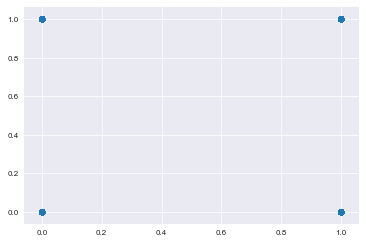

In [19]:
plt.scatter(trace.get_values('red'), trace.get_values('r'))

In [41]:
any(map(lambda x: x!=[1], trace.get_values('c_p')))

False

In [31]:
for red, r, blue in zip(trace.get_values('red'), trace.get_values('r'), trace.get_values('blue')):
    print(red, r, blue, c)

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0] [0] c
[0] [0

In [4]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

In [5]:
import pymc3 as pm, theano.tensor as tt


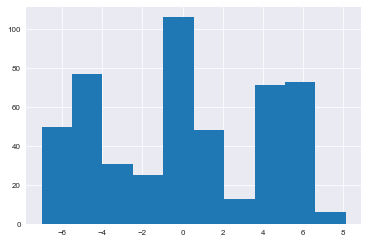

In [6]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [7]:
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))


    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [8]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    tr = pm.sample(10000, step=[step1, step2])

/afs/inf.ed.ac.uk/user/s12/s1202144/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sd_interval__]
>>Metropolis: [p_stickbreaking__]
>ElemwiseCategorical: [category]
100%|██████████| 10500/10500 [01:24<00:00, 124.48it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


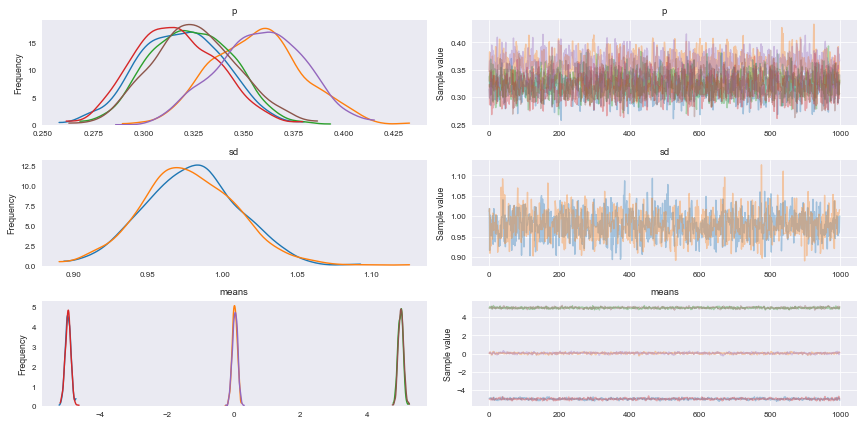

In [9]:
pm.plots.traceplot(tr[5000::5], ['p', 'sd', 'means']);

In [28]:
k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data1 = centers[v] + np.random.randn(ndata)

In [29]:
data1

array([-6.87320875e-02,  4.06297921e+00,  4.07669624e+00, -4.87475728e+00,
       -4.99543496e+00, -1.47669947e+00, -4.52796693e+00, -4.02267473e+00,
       -4.41649421e+00,  6.30217823e+00, -5.16011180e+00,  1.47493603e-01,
        3.15002120e+00, -1.09165256e+00,  5.84296841e+00, -4.61095523e+00,
       -4.18047689e+00,  6.05432664e+00, -3.60877809e+00,  4.01913325e+00,
        1.11897713e+00, -4.49161053e+00, -6.87381782e-02,  2.29844861e-01,
        4.13746155e+00, -9.26161570e-01,  1.57840680e+00,  5.36867017e+00,
       -4.44113435e+00,  7.49630661e-01, -5.67311765e+00,  4.51276193e+00,
        3.51498671e+00, -5.06827712e+00, -4.33467437e-02, -5.76359823e+00,
       -4.46181390e+00, -5.12850068e+00,  6.92716794e-01, -4.49527143e-01,
        5.73869402e+00,  4.19640236e+00,  4.67875357e-01, -9.09864030e-01,
       -8.57068614e-01,  6.22283440e+00, -5.19019675e+00,  4.83938571e+00,
        4.38449972e+00, -1.14730024e+00,  3.13515132e-01,  5.84951238e+00,
        5.97057408e+00,  

In [91]:
means

means

In [92]:
pm.summary(tr)

KeyboardInterrupt: 

Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [test:r, test:a, test:c, test:g]
INFO:pymc3:BinaryGibbsMetropolis: [test:r, test:a, test:c, test:g]
100%|██████████| 600/600 [00:01<00:00, 507.07it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In [62]:
pm.summary(test_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
test:r__0,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:a__0,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:a__1,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:a__2,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:a__3,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:a__4,0.500,0.500000,0.000000e+00,0.0,1.0,200.0,0.994987
test:c__0,0.090,0.286182,1.920937e-02,0.0,1.0,192.0,0.996203
test:c__1,0.120,0.324962,2.135416e-02,0.0,1.0,200.0,0.998763
test:c__2,0.105,0.306553,2.036541e-02,0.0,1.0,200.0,0.995252
test:c__3,0.100,0.300000,2.000000e-02,0.0,1.0,200.0,0.994987


In [65]:
pm.summary(test_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
test:r__0,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:a__0,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:a__1,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:a__2,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:a__3,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:a__4,0.500,0.500000,0.000000,0.0,1.0,200.0,0.994987
test:c__0,0.080,0.271293,0.018330,0.0,1.0,200.0,0.996340
test:c__1,0.105,0.306553,0.020365,0.0,1.0,112.0,1.008043
test:c__2,0.105,0.306553,0.020365,0.0,1.0,200.0,1.008043
test:c__3,0.100,0.300000,0.020000,0.0,1.0,200.0,0.996094


In [72]:
c_data[colours==1]

array([[0.02571199, 0.03942664, 0.93026434],
       [0.135372  , 0.14155856, 0.87535097]])

In [70]:
colours

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0])

In [73]:
u0 = 0.5
sigm = 0.1
sigm0 = 1


In [74]:
def bayes_update(u0, sigm, sigm0, x):
    un = sigm0/(sigm0 + sigm)*x + sigm/(sigm0 + sigm)*u0
    sigmn = sigm0*sigm/(sigm0 + sigm)
    return un, sigmn

In [85]:
def MAP(u0, sigm, sigm0, xs):
    n = len(xs)
    uhat = 1/n*sum(xs)
    un = n*sigm0/(n*sigm0 + sigm)*uhat + sigm/(n*sigm0 + sigm)*u0
    sigmn = sigm0*sigm/(n*sigm0 + sigm)
    return un, sigmn

In [75]:
u1, sigm1 = bayes_update(u0, sigm, sigm0,  0.93026434)

In [76]:
u1

0.8911494

In [77]:
sigm1

0.09090909090909091

In [78]:
u2, sigm2 = bayes_update(u1, sigm, sigm1,  0.87535097)

In [79]:
u2

0.883626338095238

In [80]:
sigm2

0.04761904761904762

In [86]:
MAP(u0, sigm, sigm0, [0.93026434, 0.87535097])

(0.883626338095238, 0.047619047619047616)

In [87]:
map_estimate = pm.find_MAP(my_model)

TypeError: No context on context stack